Dados limpos: 24472 registros prontos para análise.


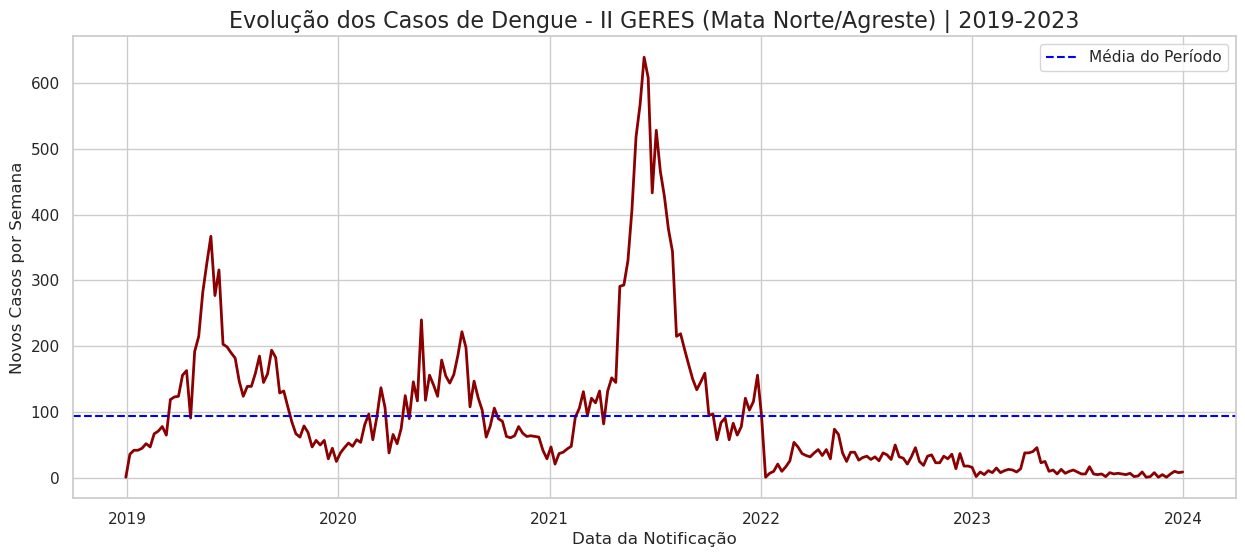

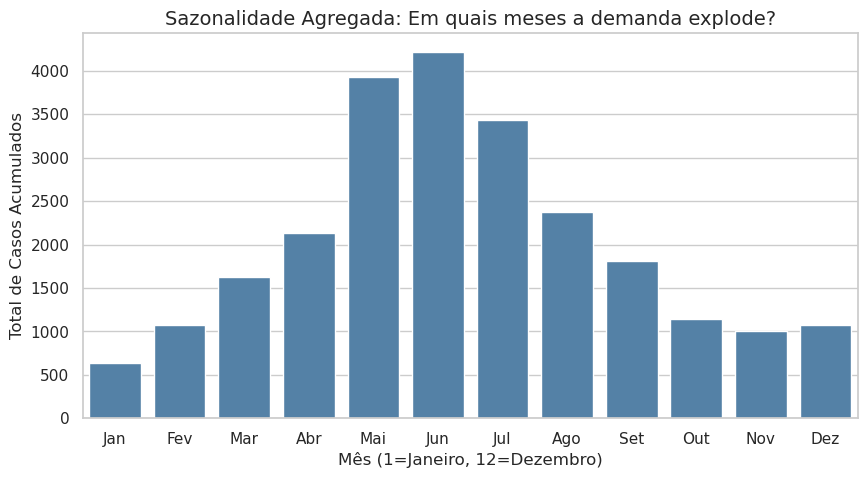

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [15, 6]

# 1. Carregar os dados
df = pd.read_parquet("dataset_dengue_II_GERES.parquet")

# 2. Converter Data (O SINAN geralmente salva como YYYY-MM-DD ou object)
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

# 3. Filtrar colunas essenciais
# DT_NOTIFIC: Data que o paciente chegou (Impacto na demanda)
# ID_MN_RESI: Onde ele mora
# SEM_NOT: Semana Epidemiológica (Muito usado na saúde)
df_clean = df[['DT_NOTIFIC', 'SEM_NOT', 'ID_MN_RESI']].copy()

# Remover datas inválidas (Nat) que podem ter vindo de erros de digitação
df_clean = df_clean.dropna(subset=['DT_NOTIFIC'])

print(f"Dados limpos: {len(df_clean)} registros prontos para análise.")
df_clean.head()

# 1. Agrupar por Semana (Resample 'W' = Weekly)
# Contamos quantos registros existem por semana
serie_temporal = df_clean.set_index('DT_NOTIFIC').resample('W').size().reset_index(name='casos')

# 2. Plotar o Gráfico
plt.figure(figsize=(15, 6))
sns.lineplot(data=serie_temporal, x='DT_NOTIFIC', y='casos', color='darkred', linewidth=2)

plt.title('Evolução dos Casos de Dengue - II GERES (Mata Norte/Agreste) | 2019-2023', fontsize=16)
plt.xlabel('Data da Notificação')
plt.ylabel('Novos Casos por Semana')
plt.axhline(y=serie_temporal['casos'].mean(), color='blue', linestyle='--', label='Média do Período')
plt.legend()
plt.show()

# Extrair o Mês da data
df_clean['mes'] = df_clean['DT_NOTIFIC'].dt.month

# Agrupar total de casos por mês (somando todos os anos)
sazonalidade = df_clean.groupby('mes').size().reset_index(name='total_casos')

# Plotar
plt.figure(figsize=(10, 5))
sns.barplot(data=sazonalidade, x='mes', y='total_casos', color='steelblue')
plt.title('Sazonalidade Agregada: Em quais meses a demanda explode?', fontsize=14)
plt.xlabel('Mês (1=Janeiro, 12=Dezembro)')
plt.ylabel('Total de Casos Acumulados')
plt.xticks(range(0, 12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def preparar_features_ml(arquivo_entrada):
    print("⚙️ Iniciando Engenharia de Atributos...")
    
    # 1. Carregar Dataset
    df = pd.read_parquet(arquivo_entrada)
    
    # Garantir que é datetime
    df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'])
    
    # 2. Agrupar por Semana Epidemiológica (Target)
    # Vamos prever o TOTAL de casos na região por semana
    df_semanal = df.set_index('DT_NOTIFIC').resample('W-SUN').size().reset_index(name='casos')
    
    # 3. Criar Features Temporais (Onde estamos no tempo?)
    df_semanal['semana_do_ano'] = df_semanal['DT_NOTIFIC'].dt.isocalendar().week.astype(int)
    df_semanal['mes'] = df_semanal['DT_NOTIFIC'].dt.month
    
    # A. Transformação Cíclica (Seno/Cosseno)
    # Explicação: O mês 12 (Dez) é muito perto do mês 1 (Jan), mas 12 e 1 são números distantes.
    # O Seno/Cosseno resolve isso aproximando o fim do ano com o começo.
    df_semanal['semana_sin'] = np.sin(2 * np.pi * df_semanal['semana_do_ano'] / 53)
    df_semanal['semana_cos'] = np.cos(2 * np.pi * df_semanal['semana_do_ano'] / 53)
    
    # B. Lags (O passado prevê o futuro)
    # Quantos casos tivemos 1 semana atrás? 2 semanas? 4 semanas?
    for lag in [1, 2, 3, 4, 8]:
        df_semanal[f'lag_w{lag}'] = df_semanal['casos'].shift(lag)
        
    # C. Médias Móveis (Tendência recente)
    # Qual a média de casos das últimas 4 semanas? (Janela deslizante)
    df_semanal['media_movel_4w'] = df_semanal['casos'].rolling(window=4).mean().shift(1)
    df_semanal['media_movel_8w'] = df_semanal['casos'].rolling(window=8).mean().shift(1)
    
    # 5. Limpeza Final
    # As primeiras semanas ficam vazias (NaN) por causa do Lag. Removemos elas.
    df_ml = df_semanal.dropna().reset_index(drop=True)
    
    print(f"✅ Dataset de Treino pronto! {df_ml.shape[0]} semanas para treinar.")
    print(df_ml.tail())
    
    return df_ml

if __name__ == "__main__":
    df_pronto = preparar_features_ml("dataset_dengue_II_GERES.parquet")
    
    # Salvar para a etapa de modelagem
    df_pronto.to_parquet("dataset_treino_ml.parquet", index=False)
    print("\n💾 Arquivo 'dataset_treino_ml.parquet' salvo.")

⚙️ Iniciando Engenharia de Atributos...
✅ Dataset de Treino pronto! 254 semanas para treinar.
    DT_NOTIFIC  casos  semana_do_ano  mes  semana_sin  semana_cos  lag_w1  \
249 2023-12-03      1             48   12   -0.558647    0.829406     5.0   
250 2023-12-10      6             49   12   -0.456629    0.889657     1.0   
251 2023-12-17     10             50   12   -0.348202    0.937420     6.0   
252 2023-12-24      8             51   12   -0.234886    0.972023    10.0   
253 2023-12-31      9             52   12   -0.118273    0.992981     8.0   

     lag_w2  lag_w3  lag_w4  lag_w8  media_movel_4w  media_movel_8w  
249     1.0     8.0     2.0     2.0            4.00           3.875  
250     5.0     1.0     8.0     3.0            3.75           3.750  
251     1.0     5.0     1.0     9.0            3.25           4.125  
252     6.0     1.0     5.0     1.0            5.50           4.250  
253    10.0     6.0     1.0     2.0            6.25           5.125  

💾 Arquivo 'dataset_tre

🧠 Iniciando Treinamento do Modelo...
📚 Dados de Treino: 201 semanas (2019-2022)
📝 Dados de Teste:  53 semanas (2023)

🎯 RESULTADOS NO TESTE (2023):
   Erro Médio Absoluto (MAE): 26.91 casos
   Raiz do Erro Quadrático Médio (RMSE): 28.27
   (A média de casos reais por semana foi 10.83)

📊 Gráfico salvo como 'resultado_previsao.png'


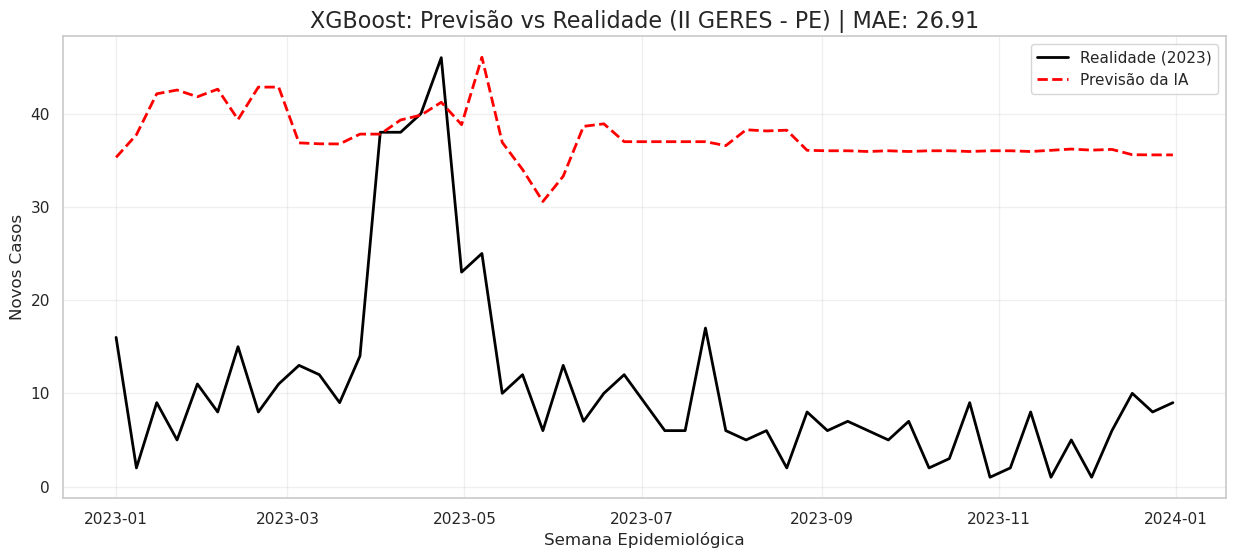

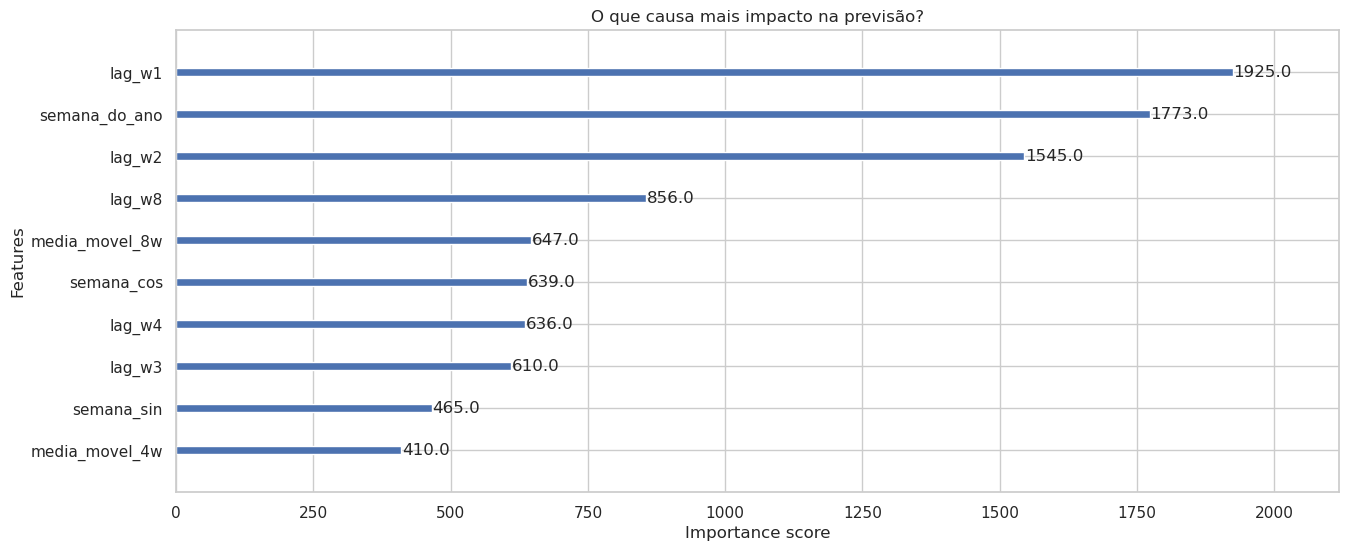

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_theme(style="whitegrid")

def treinar_modelo(arquivo_entrada):
    print("🧠 Iniciando Treinamento do Modelo...")
    
    # 1. Carregar Dataset Preparado
    df = pd.read_parquet(arquivo_entrada)
    
    # 2. Definir o Ponto de Corte (Split Cronológico)
    # Vamos usar 2023 inteirinho para testar se o modelo aprendeu a dinâmica
    # Como temos a coluna 'semana_do_ano' e 'ano_base' não está explicita, vamos pelo índice ou data
    # Mas no script anterior eu não salvei a coluna 'ano_base', então vamos usar a data
    
    # Ordenar por data (Seguro morreu de velho)
    df = df.sort_values('DT_NOTIFIC')
    
    # Data de Corte: 01/01/2023
    data_corte = pd.to_datetime('2023-01-01')
    
    # Separar Treino (Passado) e Teste (Futuro)
    train = df[df['DT_NOTIFIC'] < data_corte].copy()
    test = df[df['DT_NOTIFIC'] >= data_corte].copy()
    
    print(f"📚 Dados de Treino: {train.shape[0]} semanas (2019-2022)")
    print(f"📝 Dados de Teste:  {test.shape[0]} semanas (2023)")
    
    # 3. Definir Features (X) e Target (y)
    # Removemos a Data e o Target das Features
    features = [col for col in df.columns if col not in ['DT_NOTIFIC', 'casos']]
    target = 'casos'
    
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    
    # 4. Treinar XGBoost
    # XGBoost é excelente para capturar padrões não lineares
    model = xgb.XGBRegressor(
        n_estimators=1000,      # Número de árvores
        learning_rate=0.01,     # Velocidade de aprendizado (menor é mais preciso, mas demora mais)
        max_depth=5,            # Profundidade da árvore (evita decorar demais)
        early_stopping_rounds=50, # Para se não melhorar mais
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # 5. Previsão e Avaliação
    previsoes = model.predict(X_test)
    
    # Tratamento: Não existem casos negativos de dengue
    previsoes = [max(0, x) for x in previsoes]
    
    # Métricas
    mae = mean_absolute_error(y_test, previsoes)
    rmse = np.sqrt(mean_squared_error(y_test, previsoes))
    
    print(f"\n🎯 RESULTADOS NO TESTE (2023):")
    print(f"   Erro Médio Absoluto (MAE): {mae:.2f} casos")
    print(f"   Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
    
    # Métrica de Negócio: Quão longe ficamos da média real?
    media_real = y_test.mean()
    print(f"   (A média de casos reais por semana foi {media_real:.2f})")
    
    # 6. Visualização (O "Money Shot" do Portfólio)
    plt.figure(figsize=(15, 6))
    
    # Plotar Realidade
    plt.plot(test['DT_NOTIFIC'], y_test, label='Realidade (2023)', color='black', linewidth=2)
    
    # Plotar Previsão
    plt.plot(test['DT_NOTIFIC'], previsoes, label='Previsão da IA', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'XGBoost: Previsão vs Realidade (II GERES - PE) | MAE: {mae:.2f}', fontsize=16)
    plt.xlabel('Semana Epidemiológica')
    plt.ylabel('Novos Casos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Salvar gráfico
    plt.savefig("resultado_previsao.png")
    print("\n📊 Gráfico salvo como 'resultado_previsao.png'")
    
    # Feature Importance (O que a IA achou mais importante?)
    xgb.plot_importance(model, max_num_features=10)
    plt.title("O que causa mais impacto na previsão?")
    plt.savefig("feature_importance.png")
    
    return model

if __name__ == "__main__":
    modelo_treinado = treinar_modelo("dataset_treino_ml.parquet")

🧠 Iniciando Treinamento (Cenário: Treino 19-21 -> Previsão 23)...
📚 Dados de Treino: 149 semanas (2019 até Dez/2021)
🚫 Dados Ignorados: O ano de 2022 foi removido do aprendizado.
📝 Dados de Teste:  53 semanas (2023)

🎯 RESULTADOS NO TESTE (2023) - SEM TREINAR COM 2022:
   Erro Médio Absoluto (MAE): 86.63 casos
   Média Real de 2023: 10.83

📊 Gráfico salvo como 'resultado_previsao_gap.png'


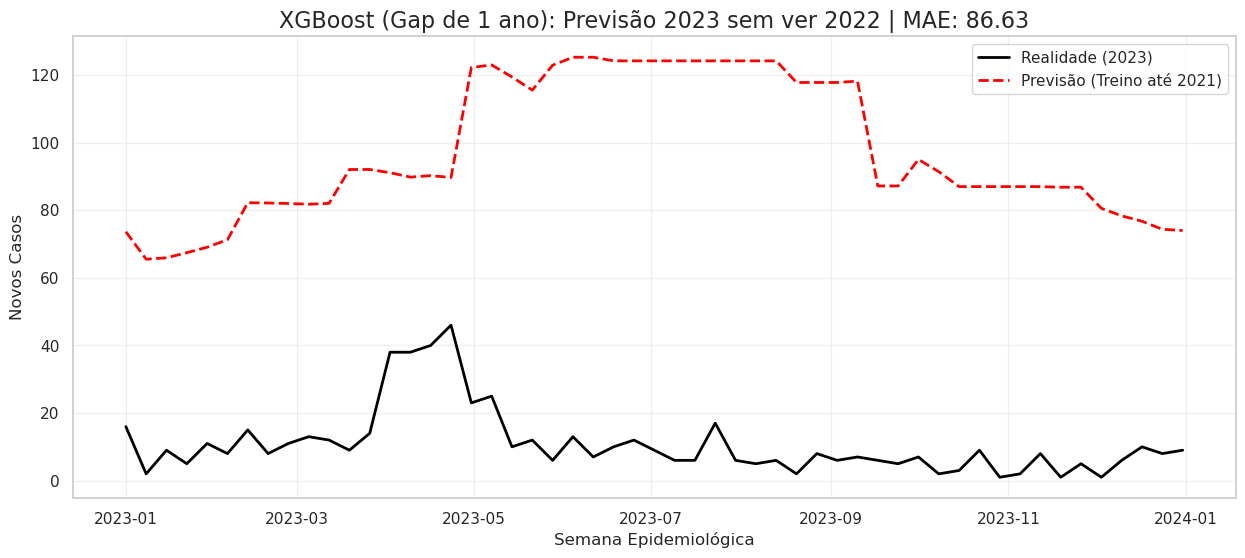

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_theme(style="whitegrid")

def treinar_modelo_com_gap(arquivo_entrada):
    print("🧠 Iniciando Treinamento (Cenário: Treino 19-21 -> Previsão 23)...")
    
    # 1. Carregar Dataset
    df = pd.read_parquet(arquivo_entrada)
    df = df.sort_values('DT_NOTIFIC')
    
    # 2. FILTRAGEM PERSONALIZADA (O Pulo do Gato)
    # Treino: Tudo antes de 2022 (Ou seja, 2019, 2020, 2021)
    mask_train = (df['DT_NOTIFIC'] < '2022-01-01')
    
    # Teste: Apenas 2023 (Pulamos 2022 inteirinho)
    mask_test = (df['DT_NOTIFIC'] >= '2023-01-01') & (df['DT_NOTIFIC'] < '2024-01-01')
    
    train = df[mask_train].copy()
    test = df[mask_test].copy()
    
    print(f"📚 Dados de Treino: {train.shape[0]} semanas (2019 até Dez/2021)")
    print(f"🚫 Dados Ignorados: O ano de 2022 foi removido do aprendizado.")
    print(f"📝 Dados de Teste:  {test.shape[0]} semanas (2023)")
    
    # 3. Setup X e y
    features = [col for col in df.columns if col not in ['DT_NOTIFIC', 'casos']]
    target = 'casos'
    
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    
    # 4. Treinar XGBoost
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        early_stopping_rounds=50,
        random_state=42
    )
    
    # Nota: Usamos X_test como validação apenas para o early_stopping não parar cedo demais,
    # mas o modelo não "treina" com esses dados.
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # 5. Previsão
    previsoes = model.predict(X_test)
    previsoes = [max(0, x) for x in previsoes] # Remove negativos
    
    # 6. Métricas
    mae = mean_absolute_error(y_test, previsoes)
    rmse = np.sqrt(mean_squared_error(y_test, previsoes))
    media_real = y_test.mean()
    
    print(f"\n🎯 RESULTADOS NO TESTE (2023) - SEM TREINAR COM 2022:")
    print(f"   Erro Médio Absoluto (MAE): {mae:.2f} casos")
    print(f"   Média Real de 2023: {media_real:.2f}")
    
    # 7. Visualização
    plt.figure(figsize=(15, 6))
    plt.plot(test['DT_NOTIFIC'], y_test, label='Realidade (2023)', color='black', linewidth=2)
    plt.plot(test['DT_NOTIFIC'], previsoes, label='Previsão (Treino até 2021)', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'XGBoost (Gap de 1 ano): Previsão 2023 sem ver 2022 | MAE: {mae:.2f}', fontsize=16)
    plt.xlabel('Semana Epidemiológica')
    plt.ylabel('Novos Casos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig("resultado_previsao_gap.png")
    print("\n📊 Gráfico salvo como 'resultado_previsao_gap.png'")
    
    return model

if __name__ == "__main__":
    modelo = treinar_modelo_com_gap("dataset_treino_ml.parquet")

🔮 Iniciando Previsão para 2024 (Modo Recursivo)...
📚 Base de Treino: 254 semanas (Até Dez/2023)
🚀 Gerando previsões para 53 semanas futuras...
✅ Previsão Concluída! Pico previsto: 37 casos.
📊 Gráfico salvo como 'previsao_2024.png'
💾 Dados da previsão salvos em 'previsao_2024_estimada.parquet'


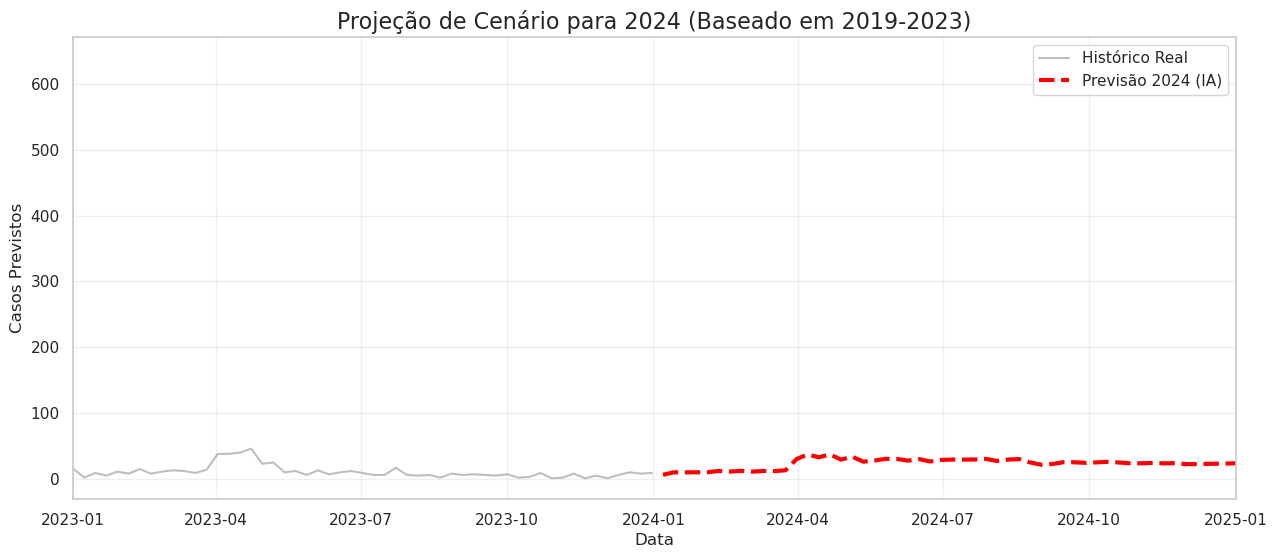

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Configuração visual
sns.set_theme(style="whitegrid")

def gerar_previsao_recursiva(arquivo_entrada):
    print("🔮 Iniciando Previsão para 2024 (Modo Recursivo)...")
    
    # 1. Carregar Dados Históricos (2019-2023)
    df = pd.read_parquet(arquivo_entrada)
    df = df.sort_values('DT_NOTIFIC')
    
    # Garantir que temos apenas dados até 2023 para o treino
    df_treino = df[df['DT_NOTIFIC'] < '2024-01-01'].copy()
    
    print(f"📚 Base de Treino: {df_treino.shape[0]} semanas (Até Dez/2023)")
    
    # 2. Treinar o Modelo com TUDO que temos
    features = [col for col in df.columns if col not in ['DT_NOTIFIC', 'casos']]
    target = 'casos'
    
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        early_stopping_rounds=50, # Precisa de eval_set, vamos improvisar separando um tiquinho do treino
        random_state=42
    )
    
    # Split interno só para o early_stopping não reclamar
    X_train = df_treino[features]
    y_train = df_treino[target]
    split_idx = int(len(X_train) * 0.9)
    
    model.fit(
        X_train.iloc[:split_idx], y_train.iloc[:split_idx],
        eval_set=[(X_train.iloc[split_idx:], y_train.iloc[split_idx:])],
        verbose=False
    )
    
    # 3. Gerar o "Esqueleto" de 2024 (Datas Futuras)
    ultima_data = df_treino['DT_NOTIFIC'].max()
    datas_2024 = pd.date_range(start=ultima_data + timedelta(weeks=1), periods=53, freq='W-SUN')
    
    print(f"🚀 Gerando previsões para {len(datas_2024)} semanas futuras...")
    
    # Lista para guardar o futuro
    futuro = []
    
    # Precisamos do histórico recente para calcular os lags (janela deslizante)
    # Pegamos as últimas 8 semanas de 2023 para começar
    historico_recente = df_treino.tail(10).copy()
    
    # --- LOOP RECURSIVO (O Pulo do Gato) ---
    for data_futura in datas_2024:
        
        # A. Criar Features de Calendário (Sazonalidade) para essa data
        semana_ano = data_futura.isocalendar().week
        nova_linha = {
            'DT_NOTIFIC': data_futura,
            'semana_do_ano': semana_ano,
            'mes': data_futura.month,
            'semana_sin': np.sin(2 * np.pi * semana_ano / 53),
            'semana_cos': np.cos(2 * np.pi * semana_ano / 53)
        }
        
        # B. Calcular Lags Baseados no Passado (Real ou Previsto)
        # Pega o histórico acumulado até agora
        base_calculo = pd.concat([historico_recente, pd.DataFrame(futuro)])
        
        # Calcula Lags manualmente
        nova_linha['lag_w1'] = base_calculo.iloc[-1]['casos'] # Semana passada
        nova_linha['lag_w2'] = base_calculo.iloc[-2]['casos'] # 2 semanas atrás
        nova_linha['lag_w3'] = base_calculo.iloc[-3]['casos']
        nova_linha['lag_w4'] = base_calculo.iloc[-4]['casos']
        nova_linha['lag_w8'] = base_calculo.iloc[-8]['casos']
        
        # Calcula Médias Móveis manualmente
        nova_linha['media_movel_4w'] = base_calculo.tail(4)['casos'].mean()
        nova_linha['media_movel_8w'] = base_calculo.tail(8)['casos'].mean()
        
        # C. Prever
        # Converte dicionário para DataFrame com as colunas na ordem certa
        input_row = pd.DataFrame([nova_linha])[features]
        
        predicao = model.predict(input_row)[0]
        predicao = max(0, predicao) # Sem casos negativos
        
        # D. Salvar e Adicionar ao Histórico (para o próximo loop usar)
        nova_linha['casos'] = predicao # Aqui a previsão vira "verdade" para o futuro
        futuro.append(nova_linha)
        
    # 4. Consolidar Resultados
    df_futuro = pd.DataFrame(futuro)
    
    print(f"✅ Previsão Concluída! Pico previsto: {df_futuro['casos'].max():.0f} casos.")
    
    # 5. Visualização
    plt.figure(figsize=(15, 6))
    
    # Histórico (2019-2023)
    plt.plot(df_treino['DT_NOTIFIC'], df_treino['casos'], label='Histórico Real', color='gray', alpha=0.5)
    
    # Futuro (2024)
    plt.plot(df_futuro['DT_NOTIFIC'], df_futuro['casos'], label='Previsão 2024 (IA)', color='red', linewidth=3, linestyle='--')
    
    plt.title('Projeção de Cenário para 2024 (Baseado em 2019-2023)', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Casos Previstos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Zoom em 2023-2024 para ver melhor a emenda
    plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2025-01-01'))
    
    plt.savefig("previsao_2024.png")
    print("📊 Gráfico salvo como 'previsao_2024.png'")
    
    # Adicione esta linha para salvar os dados:
    df_futuro.to_parquet("previsao_2024_estimada.parquet", index=False)
    print("💾 Dados da previsão salvos em 'previsao_2024_estimada.parquet'")
    
    return df_futuro

if __name__ == "__main__":
    # Usa o dataset preparado anteriormente
    gerar_previsao_recursiva("dataset_treino_ml.parquet")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pysus import SINAN
import gc

# Configuração visual
sns.set_theme(style="whitegrid")

# Códigos da II GERES (Mata Norte + Agreste) - 6 Dígitos
codigos_municipios = [
    "260290", "260410", "260845", "260850", "260950", "261060", "261560", "261640",
    "260190", "260415", "260500", "260540", "260800", "260890", "260900", "260990", 
    "261040", "261230", "261450", "261618"
]

def baixar_real_2024():
    print("🌍 Tentando baixar dados preliminares de 2024...")
    try:
        sinan = SINAN().load()
        # Tenta pegar o arquivo de 2024
        files = sinan.get_files('DENG', year=2024)
        
        if not files:
            print("⚠️ Arquivo de 2024 ainda não disponível no servidor público.")
            return None
            
        print("   ⬇️ Baixando arquivo BRASIL 2024 (Isso pode demorar)...")
        parquet_set = sinan.download(files)
        df_br = parquet_set.to_dataframe()
        
        # Filtra Região
        if 'ID_MN_RESI' in df_br.columns:
            df_br['ID_MN_RESI'] = df_br['ID_MN_RESI'].astype(str).str.strip()
            df_pe = df_br[df_br['ID_MN_RESI'].isin(codigos_municipios)].copy()
            
            # Converte data
            df_pe['DT_NOTIFIC'] = pd.to_datetime(df_pe['DT_NOTIFIC'])
            
            # Agrupa por semana (igual fizemos no treino)
            df_real = df_pe.set_index('DT_NOTIFIC').resample('W-SUN').size().reset_index(name='casos_reais')
            
            print(f"   ✅ Sucesso! {len(df_pe)} notificações encontradas em 2024.")
            return df_real
        
        return None

    except Exception as e:
        print(f"❌ Erro ao baixar 2024: {e}")
        return None

def comparar_cenarios():
    # 1. Carregar a Previsão da IA (que salvamos no passo anterior)
    try:
        df_previsto = pd.read_parquet("previsao_2024_estimada.parquet")
        df_previsto['DT_NOTIFIC'] = pd.to_datetime(df_previsto['DT_NOTIFIC'])
    except:
        print("❌ Erro: Rode o script anterior primeiro para gerar 'previsao_2024_estimada.parquet'")
        return

    # 2. Baixar o Real
    df_real = baixar_real_2024()
    
    if df_real is None:
        print("⚠️ Não foi possível comparar. Encerrando.")
        return

    # 3. Visualização do Confronto
    plt.figure(figsize=(15, 7))
    
    # Plot Realidade
    plt.plot(df_real['DT_NOTIFIC'], df_real['casos_reais'], 
             label='REALIDADE 2024 (SINAN)', color='black', linewidth=3)
    
    # Plot Previsão
    plt.plot(df_previsto['DT_NOTIFIC'], df_previsto['casos'], 
             label='PREVISÃO IA (Recursiva)', color='red', linestyle='--', linewidth=2)
    
    plt.title('Validação Final: O Modelo previu o surto de 2024?', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Casos Semanais')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    filename = "validacao_final_2024.png"
    plt.savefig(filename)
    print(f"\n📊 Gráfico salvo: {filename}")
    
    # Cálculo do Erro na "Vida Real"
    # Precisamos alinhar as datas para calcular métricas
    df_merge = pd.merge(df_real, df_previsto, on='DT_NOTIFIC', how='inner')
    
    if not df_merge.empty:
        diff_total = df_merge['casos_reais'].sum() - df_merge['casos'].sum()
        print(f"\n📢 RELATÓRIO DE IMPACTO:")
        print(f"   Total de Casos Reais: {df_merge['casos_reais'].sum()}")
        print(f"   Total Previsto pela IA: {df_merge['casos'].sum():.0f}")
        print(f"   Diferença (Gap): {diff_total:.0f} casos não previstos.")

if __name__ == "__main__":
    comparar_cenarios()